## Develop a model on Breast Cancer Dataset using TF, NN and Feature Columns API. Then, test new model deployment functionality

In [1]:
import time
import os
import random as rn

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import tensorflow as tf

# conda env: mlcpuv1
import keras2onnx
import onnxruntime as rt

In [2]:
# check TF version (> 2.3)
print('TF version', tf.__version__)
print('ONNX runtime version', rt.__version__)
print('keras2onnx version', keras2onnx.__version__)

TF version 2.3.1
ONNX runtime version 1.4.0
keras2onnx version 1.7.0


In [3]:
# to get more reproducible results with tf training
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

tf.random.set_seed(1234)

In [4]:
# we take the dataset from Sklearn
data = load_breast_cancer(as_frame=True)

# I prefer working with Dataframe
orig_df = data.frame

In [5]:
orig_df.shape

(569, 31)

In [6]:
orig_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [7]:
orig_df['target'].unique()

array([0, 1])

In [8]:
orig_df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [9]:
# we must rename columns, to remove spaces in names
# otherwise we get problems with ONNX

# substitute all spaces with _
dict_columns = {}

for col in orig_df.columns:
    dict_columns[col] = col.replace(" ", "_")

orig_df = orig_df.rename(columns=dict_columns)

In [10]:
orig_df.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension',
       'target'],
      dtype='object')

In [11]:
# Split the dataset in train, valid, test

N_TOTAL = orig_df.shape[0]
FRAC_TRAIN = 0.7
FRAC_VALID = 0.15

N_TRAIN = int(N_TOTAL * FRAC_TRAIN)
N_VALID = int(N_TOTAL * FRAC_VALID)
N_TEST = N_TOTAL - N_TRAIN - N_VALID

print('Numbers of samples for (total, train, valid, test):', N_TOTAL, N_TRAIN, N_VALID, N_TEST)

# shuffle the data
orig_df = orig_df.sample(frac=1.)

df_train = orig_df.iloc[:N_TRAIN]
df_valid = orig_df.iloc[N_TRAIN:N_TRAIN+N_VALID]
df_test = orig_df.iloc[N_TRAIN+N_VALID:]

Numbers of samples for (total, train, valid, test): 569 398 85 86


In [12]:
# global constant
BATCH_SIZE = 8
EPOCHS = 25

ONNX_MODEL_FILE = 'modelbc-artifact/modelbc.onnx'

In [13]:
# to convert in TF dataset
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32, shuffle=True):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    if shuffle:
        # don't shuffle test
        ds = ds.shuffle(buffer_size=len(df))
        
    ds = ds.batch(batch_size)
    return ds

In [14]:
# TF datasets
ds_train = df_to_dataset(df_train, 'target', batch_size=BATCH_SIZE)
ds_valid = df_to_dataset(df_valid, 'target', batch_size=BATCH_SIZE)
ds_test = df_to_dataset(df_test, 'target', batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# crate a batch for normalization test
iter1 = iter(ds_train)

batch1 = next(iter1)[0]

In [16]:
# l'uso della Column Feature API è semplice, sono tutte colonne numeriche (float)
# devo solo normalizzare

# devo prendere medie e std per la normalizzazione soltanto dal train set

# helper functions
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

# a single function for all features (in input mean, std)
def normalize(mean, std):
    '''
    This function can be used in conjunction with the tf feature column for normalization
    '''
    def norm_func(col):
        col = tf.cast(col, tf.float32)
        
        return (col - mean)/std
    
    return norm_func

def create_tf_numeric_feature(col, MEAN, STD):
    '''
    col: string, input numerical column name
    MEAN: the mean for the column 
    STD: the standard deviation for the column
    default_value: the value that will be used for imputing the field
    return:
        tf_numeric_feature: tf feature column representation of the input field
    '''
    tf_numeric_feature = tf.feature_column.numeric_column(col, dtype=tf.dtypes.float32, 
                                                          normalizer_fn=normalize(MEAN, STD))
    return tf_numeric_feature

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)

        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

def demo(feature_column, example_batch):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column, dtype='float32')
    print(feature_layer(example_batch))

In [73]:
selected_features_list = ['mean_radius', 'mean_smoothness', 'mean_compactness', 'mean_texture', 'mean_symmetry','mean_concavity','mean_fractal_dimension',
                         'radius_error', 'texture_error', 'smoothness_error',
                         'worst_radius', 'worst_texture', 'worst_symmetry']

print('We have selected', len(selected_features_list), 'features')

We have selected 13 features


In [19]:
tf_num_list = create_tf_numerical_feature_cols(selected_features_list, df_train)

In [20]:
tf_num_list

[NumericColumn(key='mean_radius', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e639e0>),
 NumericColumn(key='mean_smoothness', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e63950>),
 NumericColumn(key='mean_compactness', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e63a70>),
 NumericColumn(key='mean_texture', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e63b00>),
 NumericColumn(key='mean_symmetry', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e63b90>),
 NumericColumn(key='mean_concavity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e63c20>),
 NumericColumn(key='mean_fractal_dime

In [21]:
test_cont_var1 = tf_num_list[0]

print("Example continuous field:\n{}\n".format(test_cont_var1))

demo(test_cont_var1, batch1)

Example continuous field:
NumericColumn(key='mean_radius', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function normalize.<locals>.norm_func at 0x7fe4d4e639e0>)

tf.Tensor(
[[-1.4228904 ]
 [-1.5240549 ]
 [-0.45617858]
 [ 0.28701133]
 [-0.4307462 ]
 [-0.5833403 ]
 [-0.80940574]
 [-0.06056404]], shape=(8, 1), dtype=float32)


In [22]:
import logging
# added to remove TF warnings !
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
        
def build_model(tf_num_list):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # layer for normalizations
    feature_layer = tf.keras.layers.DenseFeatures(tf_num_list, name='layer0')
    
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(8, activation='relu', name='layer1'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu', name='layer2'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu', name='layer3'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu', name='layer4'),
        tf.keras.layers.Dropout(0.2),
        
        # Output logits here, for better numerical stability
        tf.keras.layers.Dense(1, name='layer5'),
    ])
    model.compile(optimizer='adam', loss=bce, metrics=['accuracy'])
    
    return model

In [23]:
model = build_model(tf_num_list)

In [24]:
tStart = time.time()

# callback to save the best model
sv = tf.keras.callbacks.ModelCheckpoint('model_save/modelbc', monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='min', save_freq='epoch')

history = model.fit(ds_train, validation_data=ds_valid, callbacks=[sv], epochs=EPOCHS, verbose=1)
    
tEla = round(time.time() - tStart, 1)
print('')
print('Elapsed time:', tEla)

Epoch 1/25
19/50 [==========>...................] - ETA: 0s - loss: 0.6544 - accuracy: 0.3882
Epoch 00001: val_loss improved from inf to 0.61542, saving model to model_save/modelbc
50/50 [==============================] - 0s 8ms/step - loss: 0.6443 - accuracy: 0.4422 - val_loss: 0.6154 - val_accuracy: 0.6118
Epoch 2/25
49/50 [============================>.] - ETA: 0s - loss: 0.5627 - accuracy: 0.6224
Epoch 00002: val_loss improved from 0.61542 to 0.53737, saving model to model_save/modelbc
50/50 [==============================] - 0s 3ms/step - loss: 0.5609 - accuracy: 0.6231 - val_loss: 0.5374 - val_accuracy: 0.8588
Epoch 3/25
27/50 [===============>..............] - ETA: 0s - loss: 0.4866 - accuracy: 0.7361
Epoch 00003: val_loss improved from 0.53737 to 0.45427, saving model to model_save/modelbc
50/50 [==============================] - 0s 2ms/step - loss: 0.5048 - accuracy: 0.7362 - val_loss: 0.4543 - val_accuracy: 0.9059
Epoch 4/25
22/50 [============>.................] - ETA: 0s - 

In [25]:
def plot_loss(hist, skip):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'][skip:], label='Training loss')
    plt.plot(hist.history['val_loss'][skip:], label='Validation loss')
    plt.title('Loss')
    plt.legend(loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show();

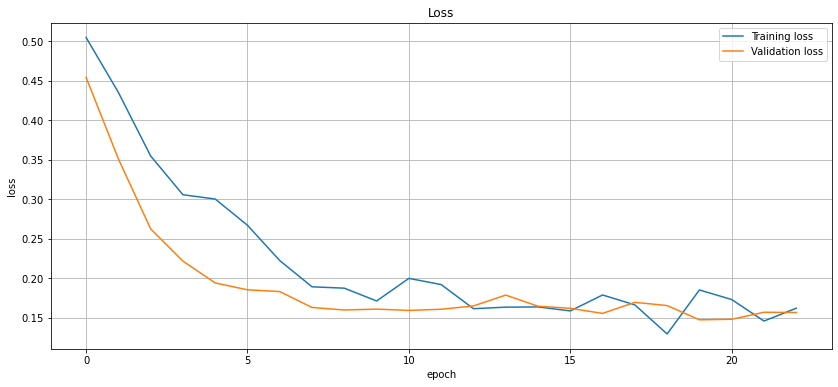

In [26]:
plot_loss(history, 2)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (DenseFeatures)       multiple                  0         
_________________________________________________________________
layer1 (Dense)               multiple                  112       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
layer2 (Dense)               multiple                  144       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
layer3 (Dense)               multiple                  272       
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0

In [28]:
# load the best model
model = build_model(tf_num_list)

model.load_weights('model_save/modelbc')

# the last layer of the model output logits... for probability I need to add a sigmoid at the end
model.add(tf.keras.layers.Activation('sigmoid'))

In [72]:
# evaluate model accuracy on TEST dataset
print('Evaluate on test set')
model.evaluate(ds_test)

# compute the confusion matrix
THRESHOLD = 0.5

y_pred = tf.cast((model.predict(ds_test) >= THRESHOLD), tf.int32)
y_true = df_test['target'].values
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print('')
print('Size of test dataset', len(y_true))
print('The confusion matrix is (tn, fp, fn, tp)', (tn, fp, fn, tp))
print('Number of errors', (fp+fn))

Evaluate on test set
11/11 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.9419

Size of test dataset 86
The confusion matrix is (tn, fp, fn, tp) (27, 4, 1, 54)
Number of errors 5


### Save in ONNX format

In [31]:
onnx_model = keras2onnx.convert_keras(model, model.name)

keras2onnx.save_model(onnx_model, ONNX_MODEL_FILE)

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 214 -> 133


### run predictions with ONNX

In [61]:
# first, a function to load the model and create an ONNX session
def create_session(onnx_file_name, print_info=False):
    sess = rt.InferenceSession(onnx_file_name)
    
    print('Loading OK')
    
    if print_info:
        print("ONNX model expects ", len(sess.get_inputs()), 'features:')
        # prints names of features
        for n, input in enumerate(sess.get_inputs()):
            print(input.name)
        
    return sess

# build the input as expected from ONNX runtime
def build_input_feed(f_batch):
    # input: the features_batch as extracted from TF dataset
    # devo costruire il dict come se lo aspetta onnx
    
    input_dict = {}
    
    # ogni feature è un singolo valore
    for col in f_batch.keys():
        # get the numpy array of values
        values = f_batch[col].numpy()
        n_rows = len(values)
        input_dict[col] = values.reshape((n_rows, 1))
    
    # input_feed is the dictionary input to ONNX model
    # for every feature a column vector (n_rows, 1)
    return input_dict

def onnx_predict(f_batch, sess=create_session(ONNX_MODEL_FILE)):
    # transform the input
    input_feed = build_input_feed(f_batch)
    
    # run inference
    pred_onnx = sess.run(None, input_feed)
    
    # build output
    output = {}
    output['probs'] = pred_onnx[0]
    
    return output

Loading OK


### now, do the test

In [64]:
# this way I take only the feature batch out of a dataset batch

# do the test on the entire test dataset
for i, f_batch in enumerate(iter(ds_test)):
    print('Batch n.', i+1)
    
    # needed
    f_batch = f_batch[0]
    
    onnx_probs = onnx_predict(f_batch)
    # print(onnx_probs)
    
    # check that preds from onnx model are equals to check from direct keras model (just to see we have not introduced bugs)
    # need to round (there are small differences)
    assert np.round(onnx_probs['probs'], 3).all() == np.round(model.predict(f_batch), 3).all()

print('')
print('ONNX test OK.')

Batch n. 1
Batch n. 2
Batch n. 3
Batch n. 4
Batch n. 5
Batch n. 6
Batch n. 7
Batch n. 8
Batch n. 9
Batch n. 10
Batch n. 11

ONNX test OK.


### prepare for model deployment